In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

from ema import read, clean


def _df() -> pd.DataFrame:
    meal_df = read.raw_meal_info()

    # Add a timestamp
    meal_df["Datetime"] = read._datetime(meal_df)
    meal_df.set_index("Datetime", inplace=True)

    # Remove early entries
    meal_df = read.add_timedelta(meal_df)
    meal_df = meal_df[meal_df["delta"].dt.days >= 0]

    # Remove late entries
    meal_df = meal_df[meal_df["delta"].dt.days <= 7]

    # Mark catchup categories
    meal_df = clean.flag_catchups(meal_df)

    return meal_df

In [3]:
"""
Find the length of catchup periods

"""
meal_df = _df()
print(meal_df["catchup_category"].value_counts())

catchup = False
start_time = None
catchup_lengths = []
start_times = []
times_since_start = []
times_in_current_period = []

for time, entry in meal_df["meal_type"].items():
    # We're currently in a catchup period
    if catchup and entry not in {"Catch-up start", "Catch-up end"}:
        times_in_current_period.append((time - start_time).seconds)

    # New catchup period started
    if entry == "Catch-up start":
        catchup = True
        start_time = time
        times_in_current_period = []

    # We've hit the end of a catchup period
    elif entry == "Catch-up end":
        catchup_lengths.append((time - start_time).seconds)

        times_since_start.append(times_in_current_period)
        start_times.append(start_time.time())
        catchup = False

# We don't need this any more
del times_in_current_period

catchup_category
Normal        66
Open-ended    24
Late           9
Early          2
Long           1
Name: count, dtype: int64


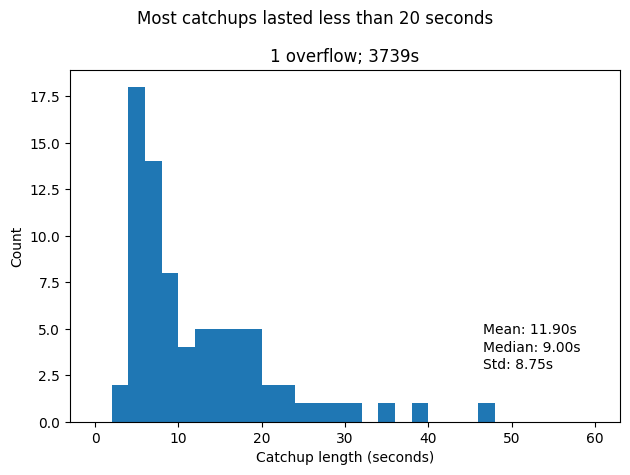

In [4]:
"""
Find how long catchups lasted

"""


import matplotlib.pyplot as plt

bins = np.linspace(0, 60, 31)

fig, axis = plt.subplots()
count, bins, artists = axis.hist(catchup_lengths, bins=bins)

axis.set_xlabel("Catchup length (seconds)")
axis.set_ylabel("Count")
fig.suptitle("Most catchups lasted less than 20 seconds")

overflow_lens = [str(l) for l in catchup_lengths if l > bins[-1]]

axis.set_title(f"{len(overflow_lens)} overflow; {', '.join(overflow_lens)}s")

# Add some stats
x_pos, y_pos = 0.75, 0.25
times_in_plot = [l for l in catchup_lengths if l < bins[-1]]
axis.text(
    x_pos, y_pos, f"Mean: {np.mean(times_in_plot):.2f}s", transform=axis.transAxes
)
axis.text(
    x_pos,
    y_pos - 0.05,
    f"Median: {np.median(times_in_plot):.2f}s",
    transform=axis.transAxes,
)
axis.text(
    x_pos, y_pos - 0.1, f"Std: {np.std(times_in_plot):.2f}s", transform=axis.transAxes
)
fig.tight_layout()

fig.savefig("img/catchup_lengths.png", dpi=300)

2


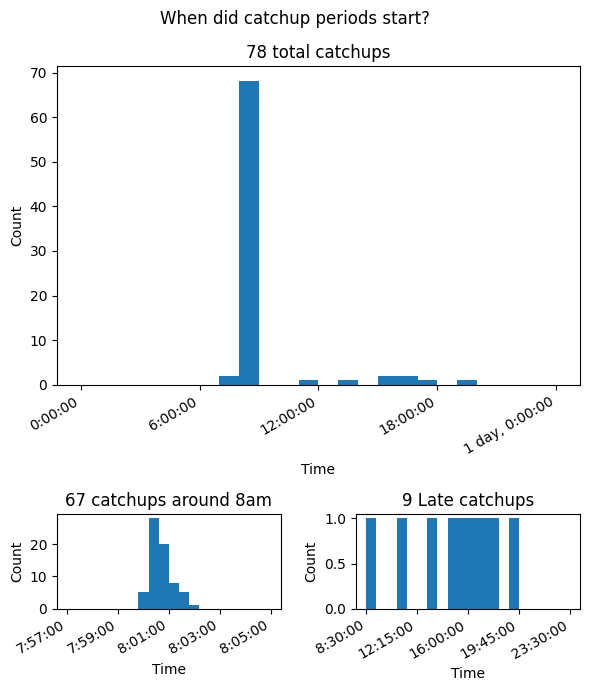

In [5]:
"""
When did they occur?

"""
import datetime

seconds_past_midnight = [
    time.hour * 3600 + time.minute * 60 + time.second for time in start_times
]


def hist(axis: plt.Axes, bins: np.ndarray, title_suffix: str, arr=None):
    """
    Plot a histogram and set the title

    """
    arr = arr or seconds_past_midnight
    counts, *_ = axis.hist(arr, bins=bins)
    axis.set_title(f"{int(np.sum(counts))} {title_suffix}")

    ticks = np.linspace(bins[0], bins[-1], 5)
    axis.set_xticks(
        ticks,
        labels=[str(datetime.timedelta(seconds=time)) for time in ticks],
        rotation=30,
        ha="right",
    )

    return int(np.sum(counts))


fig, axes = plt.subplot_mosaic("AAAA\nAAAA\nBBCC", figsize=(6, 7))

# The whole period
all_bins = np.linspace(0, 24 * 3600, 25)
total = hist(axes["A"], all_bins, "total catchups")

# Around 8am
early_bins = 3600 * 8 + 60 * np.linspace(-3, 5, 21)
early = hist(axes["B"], early_bins, "catchups around 8am")

# Later in the afternoon/evening
late_bins = 3600 * 8.5 + 3600 * np.linspace(0, 15, 21)
late = hist(axes["C"], late_bins, "Late catchups")

fig.suptitle("When did catchup periods start?")

# There also may be some missing
print(total - (early + late))

for axis in axes.values():
    axis.set_xlabel("Time")
    axis.set_ylabel("Count")
# fig.autofmt_xdate()
fig.tight_layout()

fig.savefig("img/catchup_times.png", dpi=300)

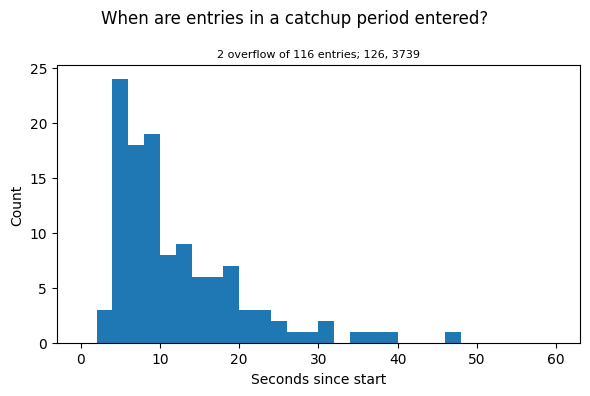

In [6]:
"""
For valid periods, how long do the entries after the start of the catchup period take?

"""
fig, axis = plt.subplots(figsize=(6, 4))

flattened_times = [a for l in times_since_start for a in l]
bins = np.linspace(0, 60, 31)

overflow_times = [str(l) for l in flattened_times if l > bins[-1]]


counts, *_ = axis.hist(
    flattened_times,
    bins=bins,
    label="Catchup period",
)

fig.suptitle("When are entries in a catchup period entered?")
axis.set_title(
    f"{len(overflow_times)} overflow of {int(np.sum(counts))} entries; {', '.join(overflow_times)}",
    fontsize=8,
)
axis.set_xlabel("Seconds since start")
axis.set_ylabel("Count")

fig.tight_layout()
fig.savefig("img/seconds_since_catchup.png")

In [7]:
"""
Quantify the different types of catchup, and how many of each there are

"""
from ema import clean

meal_df = _df()

# Add a timestamp
meal_df["Datetime"] = read._datetime(meal_df)
meal_df.set_index("Datetime", inplace=True)

# Mark cachups

In [29]:
print(meal_df["catchup_category"].value_counts())
meal_df[meal_df["catchup_category"] == "Open-ended"]

catchup_category
Normal        66
Open-ended    24
Late           9
Early          2
Long           1
Name: count, dtype: int64


,x_id,timestamp,meal_type,portion_size,utensil,location,date,week_day,p_id,ramadanstart,ramadanend,firstdate,lastdate,ramadanflag_whole_period,ramadanflag_part_period,delta,catchup_category
Datetime,,,,,,,,,,,,,,,,,
2022-02-11 20:02:05,439,20:02:05,Catch-up start,No response,No response,No response,11feb2022,Friday,8502,03apr2022,01may2022,9 Feb 22,17 Feb 22,0,0,1 days 20:02:05,Open-ended
2022-02-14 20:26:30,489,20:26:30,Catch-up start,No response,No response,No response,14feb2022,Monday,8502,03apr2022,01may2022,9 Feb 22,17 Feb 22,0,0,4 days 20:26:30,Open-ended
2022-04-19 08:01:14,205,08:01:14,Catch-up start,No response,No response,No response,19apr2022,Tuesday,8158,03apr2022,01may2022,30 Mar 22,25 Apr 22,0,1,1 days 08:01:14,Open-ended
2022-06-27 15:53:14,416,15:53:14,Catch-up start,No response,No response,No response,27jun2022,Monday,35265,03apr2022,01may2022,23 Jun 22,4 Jul 22,0,0,3 days 15:53:14,Open-ended
2021-12-31 22:11:10,387,22:11:10,Catch-up start,No response,No response,No response,31dec2021,Friday,3383,03apr2022,01may2022,22 Dec 21,4 Jan 22,0,0,4 days 22:11:10,Open-ended
2022-05-24 07:25:36,90,07:25:36,Catch-up start,No response,No response,No response,24may2022,Tuesday,28788,03apr2022,01may2022,11 May 22,30 May 22,0,0,1 days 07:25:36,Open-ended
2022-03-21 08:01:57,113,08:01:57,Catch-up start,No response,No response,No response,21mar2022,Monday,26273,03apr2022,01may2022,11 Jan 22,24 Mar 22,0,0,5 days 08:01:57,Open-ended
2022-03-07 18:33:30,558,18:33:30,Catch-up start,No response,No response,No response,07mar2022,Monday,26190,03apr2022,01may2022,2 Mar 22,16 Mar 22,0,0,0 days 18:33:30,Open-ended
2022-03-07 18:37:08,560,18:37:08,Catch-up start,No response,No response,No response,07mar2022,Monday,26190,03apr2022,01may2022,2 Mar 22,16 Mar 22,0,0,0 days 18:37:08,Open-ended


In [9]:
"""
For normal catch-ups, how long was the first entry after "Catch-up end"?

"""
normal_catchup = False
unusual_catchup = False
end_found = False
end_time = None
normal_deltas = []
unusual_deltas = []
# Iterate through rows
for time, row in meal_df.iterrows():
    # If it's a normal catchup, set a flag
    if row["catchup_category"] in {"Normal", "Long", "Early", "Late"}:
        if row["catchup_category"] == "Normal":
            normal_catchup = True
        else:
            unusual_catchup = True
        continue

    # If it's a catchup end and we're in a normal catchup, set a flag and record the time
    if (normal_catchup or unusual_catchup) and row["meal_type"] == "Catch-up end":
        end_found = True
        end_time = time
        continue

    # If we've just passed the end of a normal catchup, record the time since the end
    if end_found:
        delta = (time - end_time).seconds
        if normal_catchup:
            normal_deltas.append(delta)
        else:
            unusual_deltas.append(delta)
        normal_catchup = False
        unusual_catchup = False
        end_found = False

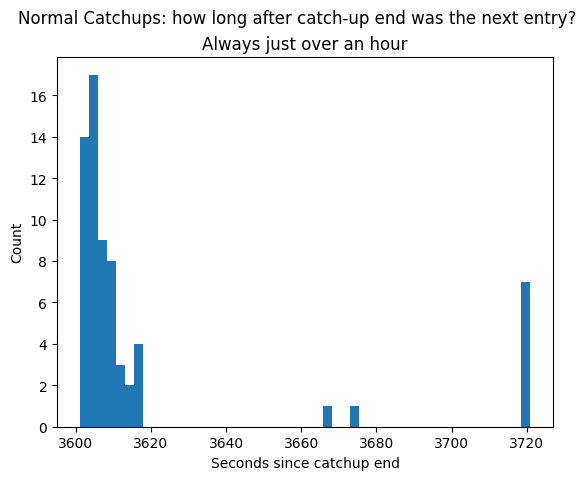

In [10]:
fig, ax = plt.subplots()

ax.hist(normal_deltas, bins=50)
ax.set_xlabel("Seconds since catchup end")
fig.suptitle("Normal Catchups: how long after catch-up end was the next entry?")
ax.set_title("Always just over an hour")
ax.set_ylabel("Count")

fig.savefig("img/time_since_catchup_end.png")

The Early and Normal entries are easy.

The long catchup was caused by a non-response to the Catchups? prompt

We'll need to look closer at the others - the late and open-ended catch-up periods...

In [11]:
"""
Look at what caused the late catchups

"""
# Let's find out which late catch ups were caused by a morning No Response
# Let's find out which late catch-ups follow a non-standard gap e.g. the watch de charging 
# Find this by checking if the is
meal_df = _df()

prev_time = None
for time, row in meal_df.iterrows():
    if row["catchup_category"] == "Open-ended":
        print(prev_time, time, f"{(time - prev_time).seconds / 60}min", sep="\t\t")
    if row["catchup_category"] != "Catch-up start":
        prev_time = time

2022-02-11 19:39:39		2022-02-11 20:02:05		22.433333333333334min
2022-02-14 19:50:40		2022-02-14 20:26:30		35.833333333333336min
2022-04-18 19:55:56		2022-04-19 08:01:14		725.3min
2022-06-26 10:01:00		2022-06-27 15:53:14		352.23333333333335min
2021-12-31 20:13:13		2021-12-31 22:11:10		117.95min
2022-05-23 20:06:00		2022-05-24 07:25:36		679.6min
2022-03-20 20:09:41		2022-03-21 08:01:57		712.2666666666667min
2022-03-07 18:11:07		2022-03-07 18:33:30		22.383333333333333min
2022-03-07 18:33:34		2022-03-07 18:37:08		3.566666666666667min
2022-03-07 19:29:08		2022-03-07 19:29:23		0.25min
2022-03-08 08:02:56		2022-03-08 08:30:40		27.733333333333334min
2022-03-08 09:01:21		2022-03-08 09:49:20		47.983333333333334min
2022-03-08 20:14:44		2022-03-09 08:00:59		706.25min
2021-12-04 20:07:49		2021-12-05 08:00:54		713.0833333333334min
2022-04-04 08:04:17		2022-04-04 08:04:36		0.31666666666666665min
2022-04-04 13:57:17		2022-04-04 14:20:29		23.2min
2021-12-23 19:36:41		2021-12-23 23:03:50		207.15min
2021

/home/mh19137/seaco_malaysia/ema/clean.py:189: UserWarning: Long catchup: not marking Meal at 2022-05-19 09:02:49 as catchup
  warnings.warn(


 Open ended catchup at 2022-02-11 20:02:05 ended by No response at 2022-02-12 08:02:11
 Open ended catchup at 2022-02-14 20:26:30 ended by No response at 2022-02-15 08:02:16
 Open ended catchup at 2022-04-19 08:01:14 ended by No catch-up at 2022-04-19 08:01:17
 Open ended catchup at 2022-06-27 15:53:14 ended by Catch-up start at 2022-06-27 15:54:06
 Open ended catchup at 2021-12-31 22:11:10 ended by No catch-up at 2022-01-01 08:01:15
 Open ended catchup at 2022-05-24 07:25:36 ended by Catch-up start at 2022-05-24 07:26:00
 Open ended catchup at 2022-03-21 08:01:57 ended by No catch-up at 2022-03-21 08:02:04
 Open ended catchup at 2022-03-07 18:33:30 ended by No catch-up at 2022-03-07 18:33:34
 Open ended catchup at 2022-03-07 18:37:08 ended by No catch-up at 2022-03-07 18:37:14
 Open ended catchup at 2022-03-07 19:29:23 ended by No response at 2022-03-08 08:02:56
 Open ended catchup at 2022-03-08 08:30:40 ended by No catch-up at 2022-03-08 08:31:08
 Open ended catchup at 2022-03-08 09:

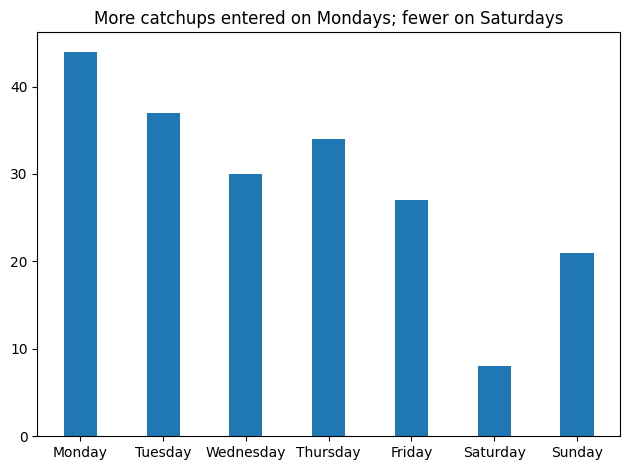

In [12]:
"""
Let's look at the day of the week the catchup entries occurred on

"""
import matplotlib.pyplot as plt

catchups_df = clean.cleaned_smartwatch(keep_catchups=True)
catchups_df = catchups_df[catchups_df["catchup_flag"]]

fig, axis = plt.subplots()

width = 0.2
bins = np.sort(np.concatenate((np.arange(7) - width, np.arange(7) + width)))
catchup_count, *_ = axis.hist(catchups_df.index.dayofweek, bins=bins)
axis.set_xticks(
    np.arange(7),
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
)

axis.set_title("More catchups entered on Mondays; fewer on Saturdays")
fig.tight_layout()

fig.savefig("img/catchups_per_day.png")

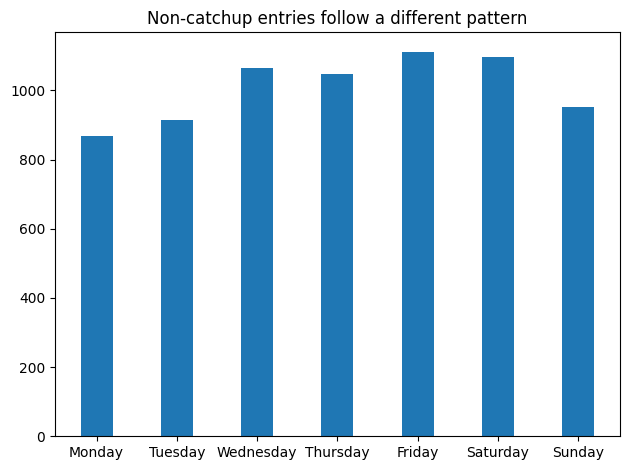

In [13]:
"""
What about non-catchup entries?

"""
normal_df = clean.cleaned_smartwatch(keep_catchups=False)

fig, axis = plt.subplots()

normal_count, *_ = axis.hist(normal_df.index.dayofweek, bins=bins)
axis.set_xticks(
    np.arange(7),
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
)

axis.set_title("Non-catchup entries follow a different pattern")
fig.tight_layout()

fig.savefig("img/non_catchups_per_day.png")

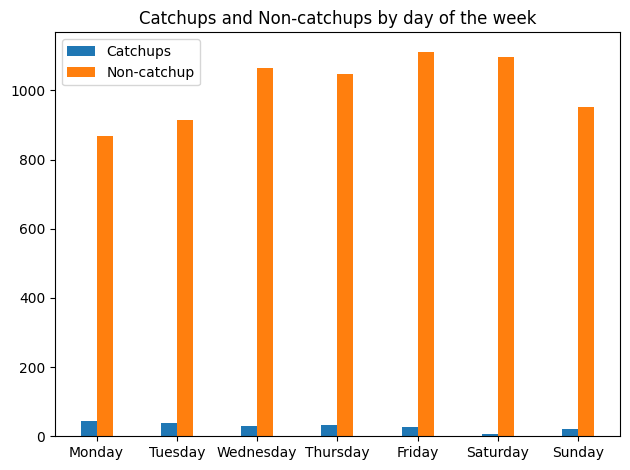

In [26]:
"""
Plot both

"""
fig, axis = plt.subplots()

# Define where to put the bars
locs = np.arange(7)

# Remove zero entries from the counts
catchup_count = catchup_count[catchup_count != 0]
normal_count = normal_count[normal_count != 0]

axis.bar(locs - width / 2, catchup_count, width, label="Catchups")
axis.bar(locs + width / 2, normal_count, width, label="Non-catchup")

axis.set_xticks(
    locs,
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
)

axis.legend()
axis.set_title("Catchups and Non-catchups by day of the week")
fig.tight_layout()

fig.savefig("img/catchup_noncatchup_by_day.png")

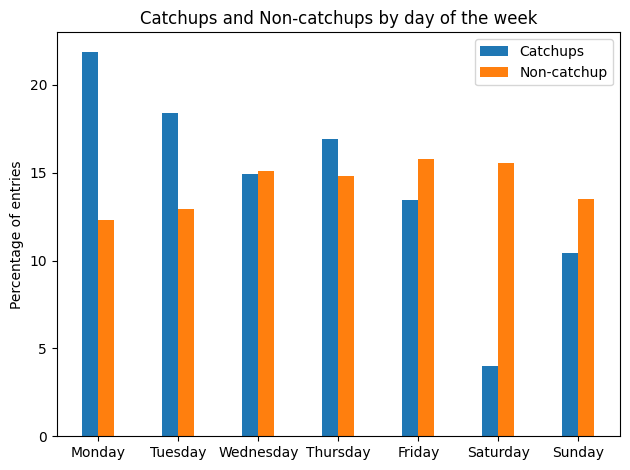

In [27]:
"""
Do it again scaled

"""
fig, axis = plt.subplots()

# Remove zero entries from the counts
catchup_count = 100 * catchup_count / np.sum(catchup_count)
normal_count = 100 * normal_count / np.sum(normal_count)

axis.bar(locs - width / 2, catchup_count, width, label="Catchups")
axis.bar(locs + width / 2, normal_count, width, label="Non-catchup")

axis.set_xticks(
    locs,
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
)

axis.legend()
axis.set_ylabel("Percentage of entries")
axis.set_title("Catchups and Non-catchups by day of the week")
fig.tight_layout()

fig.savefig("img/catchup_noncatchup_by_day_scaled.png")